Project:

The objective of the project is to build a Machine Learning model to classify a picture of a hand among different sign language characters. The process described in this Jupyter notebook is as follows:

1. First simulation of a model under a defined structure and values of parameters
2. Second simulation by changing the structure of the model, but with a set of fixex parameters
3. Using the first simulation, but now finding optimal parameters by using Bayesian Optimization (Hyperparameters tunning)
4. Hyperparameters tunning for the extended model from the first simulation

This process will show the evolution of the precision of the Machine Learning model by seeing the efects of the Hyperparameters and the layers configuration of the model. Since this is an image classification problem, the solution involves training a Convolutional Neural Network.

In [1]:
#pip install torch

In [2]:
#pip install pandas

In [3]:
#pip install numpy

In [4]:
#pip install scikit-optimize

Gemeral loading and visualization of the dataset

In [5]:
#Libraries imports
import torch
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import pandas as pd

In [6]:
#First, we define the paths of the data downloaded from Kaggle (https://www.kaggle.com/datasets/datamunge/sign-language-mnist)
train_csv_path = 'data/sign_mnist_train.csv'
test_csv_path = 'data/sign_mnist_test.csv'

In [7]:
#First we will load one dataset and see the structure
data = pd.read_csv(train_csv_path)
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [8]:
#And now we define a load function that puts the information in variables
def load_data(csv_path):
    data = pd.read_csv(csv_path)
    labels = data['label'].values
    images = data.drop(columns=['label']).values
    images = images.reshape(-1, 28, 28)
    return images, labels

In [9]:
# And now load the information
train_images, train_labels = load_data(train_csv_path)
test_images, test_labels = load_data(test_csv_path)

Missing label: 9 (J) nor 25 (Z) according to the definition from  https://www.kaggle.com/datasets/datamunge/sign-language-mnist?resource=download
It goes from 0 to 24
So we need to classify in 23 categories but carefull with 9, since It does not have any data

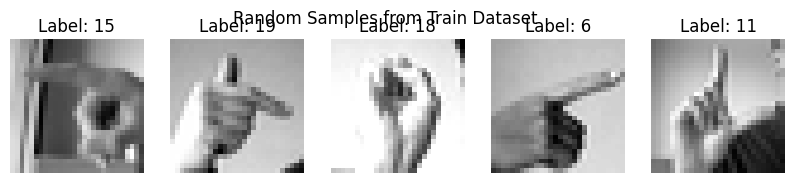

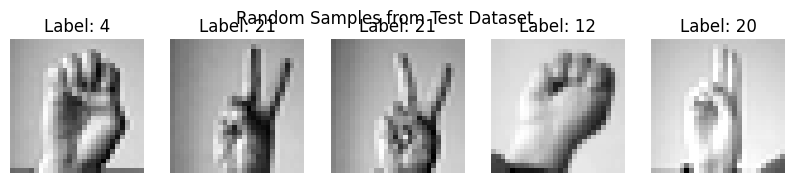

In [10]:
#Now we will visualize some of the available data
def visualize_random_images(images, labels, num_images=5, dataset_name="Train"):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        index = random.randint(0, len(images) - 1)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[index], cmap='gray')
        plt.title(f"Label: {labels[index]}")
        plt.axis('off')
    plt.suptitle(f"Random Samples from {dataset_name} Dataset")
    plt.show()

#5 from the train dataset
visualize_random_images(train_images, train_labels, num_images=5, dataset_name="Train")


visualize_random_images(test_images, test_labels, num_images=5, dataset_name="Test")

In [11]:
#Definition of the class for the dataset
class SignLanguageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype('float32')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [12]:
# Transformation for the normalization of the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Creation of the train and test datasets
train_dataset = SignLanguageDataset(train_images, train_labels, transform=transform)
test_dataset = SignLanguageDataset(test_images, test_labels, transform=transform)

#Now I divide the train dataset into a training and validation dataset using a random split, 20% for the validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

#Creation of dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


1. First Model Training

In [13]:
#Model architecture definition
class SignLanguageCNN_1(nn.Module):
    def __init__(self, num_classes):
        super(SignLanguageCNN_1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
#Creation of the model
num_classes = 25 # I fixed the value because there is no data for classification 9
model_1 = SignLanguageCNN_1(num_classes)

# Optimizer definition and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)

In [15]:
# Model training
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader: #loads images and labels in batches (batch size = 32). It goes through all the train dataset
            optimizer.zero_grad()
            outputs = model(images) #predictions
            loss = criterion(outputs, labels) #calculate loss
            loss.backward() #computes gradients of the loss with respect to the parameters
            optimizer.step() #update model's parameters
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

        # Validación
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f"Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%")

train_model(model_1, train_loader, val_loader)

Epoch 1/10, Loss: 1.5244497884616657
Validation Loss: 0.04284168217943028, Accuracy: 98.54307047896557%
Epoch 2/10, Loss: 0.05321866661532859
Validation Loss: 0.2012568964666232, Accuracy: 94.26334001092697%
Epoch 3/10, Loss: 0.03111758856354835
Validation Loss: 0.03150974584110203, Accuracy: 99.05299581132763%
Epoch 4/10, Loss: 0.0611655487825428
Validation Loss: 0.005114414220072429, Accuracy: 99.78146057184483%
Epoch 5/10, Loss: 0.0006435196466681862
Validation Loss: 0.004831651959875671, Accuracy: 99.89073028592242%
Epoch 6/10, Loss: 0.08137612352079995
Validation Loss: 0.0021235022199276544, Accuracy: 99.96357676197414%
Epoch 7/10, Loss: 0.0005786251569844953
Validation Loss: 0.0003462717217702405, Accuracy: 100.0%
Epoch 8/10, Loss: 0.00011011281366923136
Validation Loss: 0.0001642923979790244, Accuracy: 100.0%
Epoch 9/10, Loss: 5.070238650487597e-05
Validation Loss: 7.439096720822606e-05, Accuracy: 100.0%
Epoch 10/10, Loss: 3.3312377882682084e-05
Validation Loss: 6.7015504964597e

In [16]:
#Now we evaluate the accuracy on the test set:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total}%")

evaluate_model(model_1, test_loader)

Test Accuracy: 85.56887897378695%


2. Change in the architecture of the CNN

In [21]:
# New CNN architecture adding Dropout layers and another fully connected layer
class SignLanguageCNN_2(nn.Module):
    def __init__(self, num_classes):
        super(SignLanguageCNN_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.22)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 60)
        self.fc3 = nn.Linear(60, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [22]:
#Creation of the second model
num_classes = 25 # I fixed the value because there is no data for classification 9
model_2 = SignLanguageCNN_2(num_classes)

# Optimizer definition and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)

In [23]:
# Train the second model
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f"Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%")

train_model(model_2, train_loader, val_loader)

Epoch 1/10, Loss: 1.3447278925642003
Validation Loss: 0.15804696947249564, Accuracy: 94.68220724822437%
Epoch 2/10, Loss: 0.3153942413194298
Validation Loss: 0.03758300644302264, Accuracy: 99.32617009652158%
Epoch 3/10, Loss: 0.16694957805015256
Validation Loss: 0.021499927162441836, Accuracy: 99.7632489528319%
Epoch 4/10, Loss: 0.14160314338431548
Validation Loss: 0.004281209241991408, Accuracy: 100.0%
Epoch 5/10, Loss: 0.11659834005019602
Validation Loss: 0.0364172180792551, Accuracy: 99.05299581132763%
Epoch 6/10, Loss: 0.09940221740418043
Validation Loss: 0.011955500734392296, Accuracy: 99.70861409579311%
Epoch 7/10, Loss: 0.08825352772224926
Validation Loss: 0.0017358714768071222, Accuracy: 99.96357676197414%
Epoch 8/10, Loss: 0.069966241105941
Validation Loss: 0.00292887509917184, Accuracy: 99.90894190493535%
Epoch 9/10, Loss: 0.07610916005468997
Validation Loss: 0.02837623325765276, Accuracy: 99.08941904935348%
Epoch 10/10, Loss: 0.08935663577699052
Validation Loss: 0.0015384457

In [24]:
#Now we evaluate the accuracy on the test set:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total}%")

evaluate_model(model_2, test_loader)

Test Accuracy: 90.0446179587284%


3. First model Hyperparameter tunning using Bayesian optimization

In [37]:
#Generalization of the definition of the class depending on variables
class SignLanguageCNN_2_param(nn.Module):
    def __init__(self, num_classes, conv1_filters=32, conv2_filters=64, kernel_size=3, pool_kernel_size=2,
                 fc1_units=128, fc2_units=60, dropout_rate=0.4, input_height=28, input_width=28):
        super(SignLanguageCNN_2_param, self).__init__()

        self.conv1 = nn.Conv2d(1, conv1_filters, kernel_size=kernel_size, stride=1, padding=1)
        self.conv2 = nn.Conv2d(conv1_filters, conv2_filters, kernel_size=kernel_size, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.conv2_filters = conv2_filters
        self.flattened_size = self.calculate_flattened_size(input_height, input_width, kernel_size, pool_kernel_size)
        self.fc1 = nn.Linear(self.flattened_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, num_classes)

    def calculate_flattened_size(self, input_height, input_width, kernel_size, pool_kernel_size):

        # Caculation after first conv layer and pooling
        conv1_out_height = (input_height + 2 * 1 - kernel_size) // 1 + 1  # padding=1, stride=1, they are fixed
        conv1_out_width = (input_width + 2 * 1 - kernel_size) // 1 + 1
        pool1_out_height = (conv1_out_height - pool_kernel_size) // 2 + 1
        pool1_out_width = (conv1_out_width - pool_kernel_size) // 2 + 1

        # After second conv layer and pooling
        conv2_out_height = (pool1_out_height + 2 * 1 - kernel_size) // 1 + 1
        conv2_out_width = (pool1_out_width + 2 * 1 - kernel_size) // 1 + 1
        pool2_out_height = (conv2_out_height - pool_kernel_size) // 2 + 1
        pool2_out_width = (conv2_out_width - pool_kernel_size) // 2 + 1

        # Returns the size for the flattening of the vectar
        return self.conv2_filters * pool2_out_height * pool2_out_width

    def forward(self, x):

        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, self.flattened_size)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [38]:
# Training and evaluation of the model
def train_and_evaluate_model(model, train_loader, val_loader, epochs=10, lr=0.001, device="cpu"):

    # Generalization to use GPUs instead of CPUs
    model.to(device)

    # Definition of loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training phase
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Validation Loss: {val_loss/len(val_loader)}, Accuracy: {accuracy}%")

    # Returns the accuracy measured in the validation set
    return accuracy


In [39]:
# Global variable to keep track of the iterations
global_iteration = 0

def objective_function(params, train_loader, val_loader, device="cpu"):

    global global_iteration
    global_iteration += 1

    print(f"Evaluación {global_iteration}/100")


    num_classes = 25
    conv1_filters = int(params['conv1_filters'])
    conv2_filters = int(params['conv2_filters'])
    kernel_size = int(params['kernel_size'])
    pool_kernel_size = int(params['pool_kernel_size'])
    fc1_units = int(params['fc1_units'])
    fc2_units = int(params['fc2_units'])
    dropout_rate = params['dropout_rate']

    # Create the model with the given parameters
    model = SignLanguageCNN_2_param(
        num_classes=num_classes,
        conv1_filters=conv1_filters,
        conv2_filters=conv2_filters,
        kernel_size=kernel_size,
        pool_kernel_size=pool_kernel_size,
        fc1_units=fc1_units,
        fc2_units=fc2_units,
        dropout_rate=dropout_rate
    )

    # Call to train and evaluate the model
    accuracy = train_and_evaluate_model(model, train_loader, val_loader, epochs=6, lr=0.001, device=device)

    # It returs the accuracy which is the parameter to be optimized.
    return -accuracy



In [40]:
# Definition of the space in which the search will be perfomed.
space = [
    Integer(20, 50, name='conv1_filters'), # Conv 1 filter
    Integer(40, 90, name='conv2_filters'), # Conv 2 filter
    Integer(3, 4, name='kernel_size'), # Kernel size
    Integer(3, 4, name='pool_kernel_size'), # Pooling size
    Integer(80, 250, name='fc1_units'), # Fully connected 1 units
    Integer(32, 120, name='fc2_units'), # Fully connected 2 units
    Real(0.2, 0.5, name='dropout_rate') # Dropout rate
]

# Bayesian optimization from scikit learn
result = gp_minimize(
    func=lambda params: objective_function(
        dict(zip(['conv1_filters', 'conv2_filters', 'kernel_size', 'pool_kernel_size', 'fc1_units', 'fc2_units', 'dropout_rate'], params)),
        train_loader=train_loader,
        val_loader=val_loader,
        device="cuda"
    ),
    dimensions=space,
    n_calls=100,  # Definition of the number of evaluation
    random_state=30
)


best_params = dict(zip(
    ['conv1_filters', 'conv2_filters', 'kernel_size', 'pool_kernel_size', 'fc1_units', 'fc2_units', 'dropout_rate'],
    result.x
))
print("Mejores Hiperparámetros:", best_params)



Evaluación 1/100
Epoch 1/6, Loss: 2.470206394119207
Validation Loss: 1.5618230998516083, Accuracy: 56.45601894008377%
Epoch 2/6, Loss: 1.6518480076713506
Validation Loss: 1.0326907069877136, Accuracy: 72.11801129120379%
Epoch 3/6, Loss: 1.2085868328853118
Validation Loss: 0.5002335503177587, Accuracy: 84.75687488617739%
Epoch 4/6, Loss: 0.8530668658373831
Validation Loss: 0.43272196666099305, Accuracy: 85.97705336004371%
Epoch 5/6, Loss: 0.6811207672784422
Validation Loss: 0.2505364866364141, Accuracy: 95.33782553268986%
Epoch 6/6, Loss: 0.5861557763086136
Validation Loss: 0.16916339101573064, Accuracy: 96.23019486432344%
Evaluación 2/100
Epoch 1/6, Loss: 1.6442594640987236
Validation Loss: 0.38809645574453266, Accuracy: 88.9819704971772%
Epoch 2/6, Loss: 0.5948409549946174
Validation Loss: 0.15757105074996172, Accuracy: 96.10271353123292%
Epoch 3/6, Loss: 0.3846581955826699
Validation Loss: 0.09552096440131928, Accuracy: 97.94208705153888%
Epoch 4/6, Loss: 0.3025103336446844
Validatio

In [41]:
best_params

{'conv1_filters': 25,
 'conv2_filters': 40,
 'kernel_size': 3,
 'pool_kernel_size': 3,
 'fc1_units': 156,
 'fc2_units': 32,
 'dropout_rate': 0.3006299947265297}

In [42]:
best_params= {'conv1_filters': 25,
 'conv2_filters': 40,
 'kernel_size': 3,
 'pool_kernel_size': 3,
 'fc1_units': 156,
 'fc2_units': 32,
 'dropout_rate': 0.3006299947265297}

Now, I will train the model again, considering the best parameters obained in the previous step.

In [43]:
def train_model(model, train_loader, val_loader, test_loader, epochs=10, lr=0.001, device="cuda"):

    model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training phase
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {running_loss/len(train_loader)}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Validation Loss: {val_loss/len(val_loader)}, Accuracy: {accuracy}%")

    # Final validation on the TEST SET and returns the accuracy for this
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss/len(test_loader)}, Test Accuracy: {test_accuracy}%")

    return test_accuracy


In [44]:
# Initialization of the model using the best parameters obtained from the hyperparameters tuning process.
best_model = SignLanguageCNN_2_param(
    num_classes=25,
    conv1_filters=int(best_params['conv1_filters']),
    conv2_filters=int(best_params['conv2_filters']),
    kernel_size=int(best_params['kernel_size']),
    pool_kernel_size=int(best_params['pool_kernel_size']),
    fc1_units=int(best_params['fc1_units']),
    fc2_units=int(best_params['fc2_units']),
    dropout_rate=best_params['dropout_rate']
)



# Call the train model function and the optimal hyperparameters.
test_accuracy = train_model(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=10,
    lr=0.001,
    device="cuda"
)

print(f"Final Test Accuracy: {test_accuracy}%")


Epoch 1/10, Training Loss: 3.074793918858102
Validation Loss: 1.8465359072352565, Accuracy: 44.09032963030413%
Epoch 2/10, Training Loss: 1.1473787888515812
Validation Loss: 0.2824424438525078, Accuracy: 92.13258058641414%
Epoch 3/10, Training Loss: 0.44246702257874576
Validation Loss: 0.07100794557482004, Accuracy: 98.87087962119833%
Epoch 4/10, Training Loss: 0.27697319363608547
Validation Loss: 0.03953252390546854, Accuracy: 99.25332362046986%
Epoch 5/10, Training Loss: 0.19637000188231468
Validation Loss: 0.017881523540275994, Accuracy: 99.56292114368968%
Epoch 6/10, Training Loss: 0.16215177987440552
Validation Loss: 0.015024282583062602, Accuracy: 99.67219085776726%
Epoch 7/10, Training Loss: 0.16015995478832326
Validation Loss: 0.013053933089310682, Accuracy: 99.7632489528319%
Epoch 8/10, Training Loss: 0.12154392243750675
Validation Loss: 0.002775125172880761, Accuracy: 99.96357676197414%
Epoch 9/10, Training Loss: 0.12630800004863216
Validation Loss: 0.006170252016640599, Accu

The final accuracy over the test set after training is 95,9%.